<a href="https://colab.research.google.com/github/Vishnutha/2022-tutorial-2/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastHeal Malware Prediction

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
from sklearn import preprocessing

In [55]:
from numpy import *
import math
import pandas as pd
import matplotlib as plt
from google.colab import files
import dask
import dask.dataframe as dd
import warnings
import numpy as np
import gc
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [56]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [57]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1qOwvhFXPkbd9yRYcNqdMkrTMVGfruZnj'
download = drive.CreateFile({'id': file_id})
download.GetContentFile('train.csv')

In [58]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [59]:
train_df  = pd.read_csv("train.csv",low_memory = False)

In [60]:
file_id2 = '14tlnGaRrcrEAY4u5xPSJgMSgW7_fUn8e'
download2 = drive.CreateFile({'id': file_id2})
download2.GetContentFile('test.csv')
test_df = pd.read_csv("test.csv",low_memory = False)
test_df.head()

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,6123525,6123525,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1429.0,0,7.0,0,NaN,...,512.0,63175.0,0,0.0,0.0,0,0,0.0,0.0,1.0
1,6557910,6557910,win8defender,1.1.15100.1,4.9.10586.672,1.273.995.0,0,7.0,0,NaN,...,355.0,19951.0,0,0.0,0.0,0,0,0.0,0.0,11.0
2,2134897,2134897,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1730.0,0,7.0,0,NaN,...,355.0,7426.0,1,NaN,0.0,0,0,0.0,0.0,11.0
3,3368859,3368859,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,NaN,...,677.0,8156.0,1,NaN,0.0,1,1,1.0,0.0,15.0
4,3354858,3354858,win8defender,1.1.15200.1,4.18.1807.18075,1.275.876.0,0,7.0,0,NaN,...,142.0,41834.0,1,0.0,0.0,0,0,0.0,0.0,7.0


In [61]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [62]:
gc.collect()

1269

In [63]:
test_df.head()

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,6123525,6123525,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1429.0,0,7.0,0,NaN,...,512.0,63175.0,0,0.0,0.0,0,0,0.0,0.0,1.0
1,6557910,6557910,win8defender,1.1.15100.1,4.9.10586.672,1.273.995.0,0,7.0,0,NaN,...,355.0,19951.0,0,0.0,0.0,0,0,0.0,0.0,11.0
2,2134897,2134897,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1730.0,0,7.0,0,NaN,...,355.0,7426.0,1,NaN,0.0,0,0,0.0,0.0,11.0
3,3368859,3368859,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,NaN,...,677.0,8156.0,1,NaN,0.0,1,1,1.0,0.0,15.0
4,3354858,3354858,win8defender,1.1.15200.1,4.18.1807.18075,1.275.876.0,0,7.0,0,NaN,...,142.0,41834.0,1,0.0,0.0,0,0,0.0,0.0,7.0


In [64]:
train_df.describe()

,Unnamed: 0,MachineIdentifier,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,1.427437e+06,1.427437e+06,1.427437e+06,1.422280e+06,1.427437e+06,69034.000000,1.421542e+06,1.421542e+06,1.421542e+06,1.427437e+06,...,1.401853e+06,1.427437e+06,521212.0,1.424803e+06,1.427437e+06,1.427437e+06,1.416211e+06,1.378774e+06,1.378774e+06,1.427437e+06
mean,4.464695e+06,4.464695e+06,5.604450e-06,6.844938e+00,1.737730e-02,1660.099183,4.784247e+04,1.326524e+00,1.020875e+00,9.880177e-01,...,3.303730e+04,4.857566e-01,0.0,7.161692e-03,1.251908e-01,3.812357e-02,5.763336e-02,2.836281e-01,7.879336e+00,4.997930e-01
std,2.575295e+06,2.575295e+06,2.367366e-03,1.027449e+00,1.306726e-01,1002.946790,1.402022e+04,5.226712e-01,1.668508e-01,1.088060e-01,...,2.120403e+04,4.997973e-01,0.0,8.432323e-02,3.309353e-01,1.914946e-01,2.330489e-01,4.507586e-01,4.549816e+00,5.000001e-01
min,8.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,2.100000e+01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.237167e+06,2.237167e+06,0.000000e+00,7.000000e+00,0.000000e+00,788.000000,4.948000e+04,1.000000e+00,1.000000e+00,1.000000e+00,...,1.315600e+04,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,4.465422e+06,4.465422e+06,0.000000e+00,7.000000e+00,0.000000e+00,1632.000000,5.344700e+04,1.000000e+00,1.000000e+00,1.000000e+00,...,3.307000e+04,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00
75%,6.693923e+06,6.693923e+06,0.000000e+00,7.000000e+00,0.000000e+00,2388.000000,5.344700e+04,2.000000e+00,1.000000e+00,1.000000e+00,...,5.243100e+04,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00
max,8.921475e+06,8.921475e+06,1.000000e+00,3.500000e+01,1.000000e+00,3212.000000,7.049600e+04,6.000000e+00,5.000000e+00,1.000000e+00,...,7.209100e+04,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01,1.000000e+00


In [65]:
test_df.describe()

,Unnamed: 0,MachineIdentifier,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
count,3.568600e+05,3.568600e+05,356860.000000,355574.000000,356860.000000,17115.000000,355404.000000,355404.000000,355404.000000,356860.000000,...,349600.000000,350575.000000,356860.000000,130475.0,356220.000000,356860.000000,356860.000000,354121.000000,344981.000000,344981.000000
mean,4.462473e+06,4.462473e+06,0.000008,6.845796,0.017242,1664.970377,47846.552844,1.327050,1.021046,0.987774,...,403.335049,33028.774981,0.486746,0.0,0.006751,0.126307,0.038231,0.057754,0.283975,7.875451
std,2.577301e+06,2.577301e+06,0.002899,1.023361,0.130172,997.318238,14028.907701,0.523197,0.167494,0.109894,...,221.321883,21227.763102,0.499825,0.0,0.081889,0.332196,0.191753,0.233279,0.450926,4.548999
min,2.100000e+01,2.100000e+01,0.000000,0.000000,0.000000,1.000000,16.000000,1.000000,0.000000,0.000000,...,11.000000,12.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.229263e+06,2.229263e+06,0.000000,7.000000,0.000000,788.000000,49480.000000,1.000000,1.000000,1.000000,...,142.000000,13154.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,4.459479e+06,4.459479e+06,0.000000,7.000000,0.000000,1632.000000,53447.000000,1.000000,1.000000,1.000000,...,500.000000,33066.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
75%,6.695464e+06,6.695464e+06,0.000000,7.000000,0.000000,2388.000000,53447.000000,2.000000,1.000000,1.000000,...,556.000000,52436.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000
max,8.921456e+06,8.921456e+06,1.000000,8.000000,1.000000,3196.000000,70492.000000,6.000000,5.000000,1.000000,...,1087.000000,72096.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000


# Preprocessing and Exploratory Data Analysis (EDA)

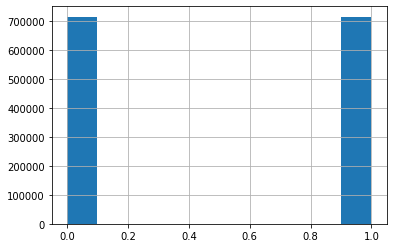

In [66]:
train_df['HasDetections'].hist()

# Checking for NULL values

In [67]:
train_df.isna().sum()

Unnamed: 0                                                 0
MachineIdentifier                                          0
ProductName                                                0
EngineVersion                                              0
AppVersion                                                 0
AvSigVersion                                               0
IsBeta                                                     0
RtpStateBitfield                                        5157
IsSxsPassiveMode                                           0
DefaultBrowsersIdentifier                            1358403
AVProductStatesIdentifier                               5895
AVProductsInstalled                                     5895
AVProductsEnabled                                       5895
HasTpm                                                     0
CountryIdentifier                                          0
CityIdentifier                                         51877
OrganizationIdentifier  

In [68]:
train_df.shape

(1427437, 84)

In [69]:
test_df.isna().sum()

Unnamed: 0                                                0
MachineIdentifier                                         0
ProductName                                               0
EngineVersion                                             0
AppVersion                                                0
AvSigVersion                                              0
IsBeta                                                    0
RtpStateBitfield                                       1286
IsSxsPassiveMode                                          0
DefaultBrowsersIdentifier                            339745
AVProductStatesIdentifier                              1456
AVProductsInstalled                                    1456
AVProductsEnabled                                      1456
HasTpm                                                    0
CountryIdentifier                                         0
CityIdentifier                                        13049
OrganizationIdentifier                  

Removing columns with NULL value > 500000 of the data

In [70]:
list_of_high_null_value_columns = []

In [71]:
for col in train_df.columns:
  if(train_df[col].isna().sum() > 500000):
    list_of_high_null_value_columns.append(col);
list_of_high_null_value_columns

['DefaultBrowsersIdentifier',
 'PuaMode',
 'SmartScreen',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']

In [72]:
train_df.drop(axis="columns", labels=list_of_high_null_value_columns, inplace=True) 
test_df.drop(axis="columns", labels=list_of_high_null_value_columns, inplace=True) 

In [73]:
train_df.shape

(1427437, 76)

In [74]:
train_df.dtypes

Unnamed: 0                                             int64
MachineIdentifier                                      int64
ProductName                                           object
EngineVersion                                         object
AppVersion                                            object
AvSigVersion                                          object
IsBeta                                                 int64
RtpStateBitfield                                     float64
IsSxsPassiveMode                                       int64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
HasTpm                                                 int64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier       

In [75]:
sel_obj_cols = list(train_df.select_dtypes(include='object'))
for col in sel_obj_cols :
  print(col + ": Null values count : "+ str(train_df[col].isna().sum()) + " Unique count : " + str(len(train_df[col].unique())))

ProductName: Null values count : 0 Unique count : 4
EngineVersion: Null values count : 0 Unique count : 59
AppVersion: Null values count : 0 Unique count : 96
AvSigVersion: Null values count : 0 Unique count : 7727
Platform: Null values count : 0 Unique count : 4
Processor: Null values count : 0 Unique count : 3
OsVer: Null values count : 0 Unique count : 26
OsPlatformSubRelease: Null values count : 0 Unique count : 9
OsBuildLab: Null values count : 5 Unique count : 524
SkuEdition: Null values count : 0 Unique count : 8
Census_MDC2FormFactor: Null values count : 0 Unique count : 12
Census_DeviceFamily: Null values count : 0 Unique count : 3
Census_PrimaryDiskTypeName: Null values count : 2077 Unique count : 5
Census_ChassisTypeName: Null values count : 100 Unique count : 42
Census_PowerPlatformRoleName: Null values count : 10 Unique count : 11
Census_OSVersion: Null values count : 0 Unique count : 340
Census_OSArchitecture: Null values count : 0 Unique count : 3
Census_OSBranch: Null v

{'CityIdentifier': 51877,
 'OrganizationIdentifier': 441283,
 'SMode': 85621,
 'Census_InternalBatteryNumberOfCharges': 42807,
 'Wdft_IsGamer': 48663,
 'Wdft_RegionIdentifier': 48663}

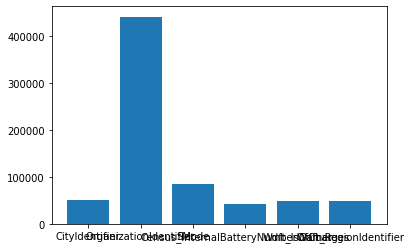

In [76]:
nulls = {}
for col in train_df.columns:
  if(train_df[col].isna().sum() > 40000):
    nulls[col] = train_df[col].isna().sum() 
# plt.bar(nulls.values(), nulls.keys(),color = 'g')
plt.bar(nulls.keys(), nulls.values())

nulls


# Filling Missing Values


Filling missing values of data type : object with mode()

In [77]:
for col in sel_obj_cols:
  train_df[col].fillna(train_df[col].mode().iloc[0], inplace = True)
  test_df[col].fillna(test_df[col].mode().iloc[0], inplace = True)


Checking Null value count

In [79]:
sel_number_cols = list(train_df.select_dtypes(include='number'))

for col in sel_number_cols:
  train_df[col].fillna(train_df[col].mean(),inplace = True)
  if(col != 'HasDetections'):
    test_df[col].fillna(test_df[col].mean(),inplace = True)

# Label Encoding 

In [81]:
label_encoder = LabelEncoder()

for col in sel_obj_cols:
  train_df[col] = label_encoder.fit_transform(train_df[col])
  test_df[col] = label_encoder.fit_transform(test_df[col])
  

# Removing Outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


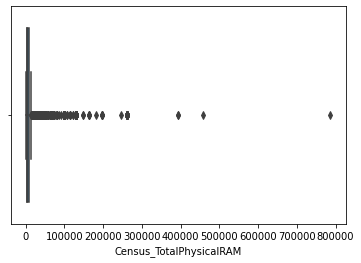

In [82]:
sns.boxplot(train_df['Census_TotalPhysicalRAM'])

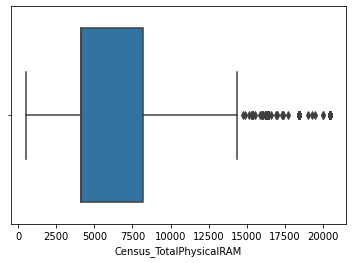

In [83]:
ram = train_df['Census_TotalPhysicalRAM'].copy()
mean_ram = ram.mean()
std_ram = ram.std()
z_score_ram = (ram - mean_ram)/std_ram
filtered_entries_ram = (np.abs(z_score_ram) <= 3)
# print(filtered_entries_ram)
ram = ram[filtered_entries_ram]
sns.boxplot(x = ram)

In [84]:
means = train_df.mean()
standard_deviation = train_df.std()
z_scores = (train_df - means)/standard_deviation
good = (np.abs(z_scores) <= 3)
filtered_entries = (np.abs(z_scores) <= 3).all(axis=1)




In [85]:
# train_df = train_df[filtered_entries]

Replacing Outliers with trimming max and min values

In [86]:

for column in train_df.columns:
    train_df.loc[z_scores[column] > 3, column] = means[column] + 3*standard_deviation[column]
    train_df.loc[z_scores[column] < -3, column] = means[column] - 3*standard_deviation[column]
    test_df.loc[z_scores[column] < -3, column] = means[column] - 3*standard_deviation[column]
    test_df.loc[z_scores[column] > 3, column] = means[column] + 3*standard_deviation[column]


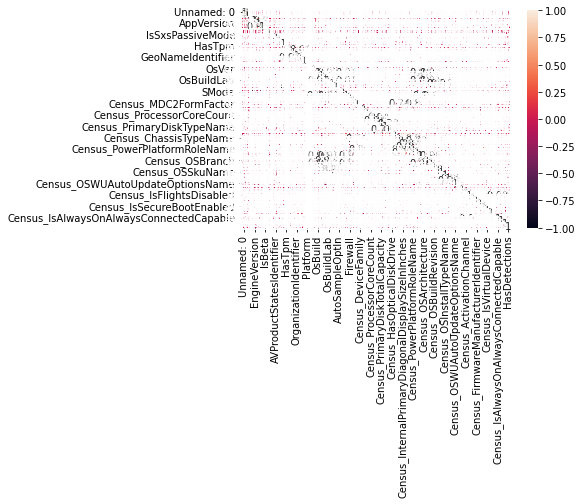

In [87]:
sns.heatmap(train_df.corr(), annot=True)

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
model = LogisticRegression()
x_train = train_df.copy()
x_train.drop(inplace = True,labels = ['HasDetections','MachineIdentifier'], axis = 'columns')
y_train = train_df['HasDetections'].copy()
model.fit(x_train,y_train)

LogisticRegression()

In [90]:
gc.collect()

141

In [91]:
y_pred = model.predict(x_train)
print("F1 score " + str(f1_score(y_train, y_pred)*100))
print("Accuracy score :" + str(accuracy_score(y_train,y_pred)*100))


F1 score 69.81316816857967
Accuracy score :53.625368392850305


In [92]:
gc.collect()

326

# Pricipal Component Analysis (PCA)

In [93]:
from sklearn.decomposition import PCA

# Assuming 10 components
pca = PCA(n_components=10)
df3 = pd.DataFrame(pca.fit_transform(x_train))
x_pca_train,x_pca_test,y_pca_train,y_pca_test = train_test_split(df3,y_train, test_size=0.2,random_state=0)
model.fit(x_pca_train,y_pca_train)
print(model.score(x_pca_test,y_pca_test)*100)

48.783506206861354


In [94]:
print(model.score(x_pca_train,y_pca_train)*100)

48.907898597874485


In [95]:
gc.collect()

206